## Lab 7

In [1]:
# %matplotlib widget
# Imports and setup
from pint import UnitRegistry
import math
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import scipy

# Use pint
units = UnitRegistry()
units.default_format = "~P"
ureg = UnitRegistry()
ureg.setup_matplotlib()
Q_ = ureg.Quantity

In [229]:
# Functions Used For Lab
def unpack_oscope(filepath):
    data = pd.read_csv(filepath)
    increment = float(data["Increment"][0])
    data = data.iloc[1: , :]
    data = data.astype(float)
    data["time"] = data["X"] * increment
    return data

def plot_vsh_vdr(voltages):
    start_tick = 0
    end_tick = -1
    
    for voltage in voltages: 
        data = unpack_oscope(f"../data/{voltage}.csv")
        fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True)  
        # Shunt voltage
        ax1.scatter(data["time"][start_tick:end_tick], data["CH1"][start_tick:end_tick], marker='.', s=0.5)
        # Drain Voltage
        ax2.scatter(data["time"][start_tick:end_tick], data["CH2"][start_tick:end_tick], marker='.', s=0.5)

        ax1.sharex(ax2)
        ax1.title.set_text("Shunt Voltage")
        ax2.title.set_text("Drain Voltage")
        ax2.set_xlabel("Time (s)")
        fig.suptitle(f"Shunt and Drain Voltage for {voltage}V") 

        plt.show()
        
def plot_ringing(names):
    start_tick = 0
    end_tick = -1
    
    for name in names: 
        data = unpack_oscope(f"../data/{name.lower().replace(' ', '_')}.csv")
        fig, ax = plt.subplots()  
        # Drain Voltage
        ax.scatter(data["time"][start_tick:end_tick], data["CH2"][start_tick:end_tick], marker='.', s=0.5)

        ax.set_title(f"{name} Frequency Drain Ringing")
        ax.set_ylabel("Drain Voltage (V)")
        ax.set_xlabel("Time (s)")

        plt.show()
        
def get_ringing_characteristics(xy1, xyn, zero, n, wo=0):
    f = n/(xyn[0] - xy1[0])
    # Choose method for calculating zeta
    if n > 2:
        d = (1/n)*math.log((xy1[1]-zero)/(xyn[1]-zero))
        zeta = d/math.sqrt(4*math.pi**2 + d**2)
    else:
        zeta = math.sqrt(1-(f/wo)**2)
    return f, zeta
    
        
def plot_vc16(voltages):
    start_tick = 0
    end_tick = -1
    fig, ax = plt.subplots()  


    for voltage in voltages: 
        data = unpack_oscope(f"../data/{voltage}.csv")
        # Drain Voltage
        ax.scatter(data["time"][start_tick:end_tick], data["CH3"][start_tick:end_tick], marker='.', s=0.5)

        
    ax.set_title("Cathode Voltages")
    ax.set_ylabel("Cathode Voltage (V)")
    ax.set_xlabel("Time (s)")
    ax.legend(["V_o = 7.00 V", "V_o = 8.08 V"])
    plt.show()
    
def curve_fit_capacitance(name, bounds, crop):
    start_tick = bounds[0]
    end_tick = bounds[1]
    fig, ax = plt.subplots()  
    
    R = 1500
    fs = 50e3
    Ts = 1/fs

    data = unpack_oscope(f"../data/{name}.csv")
    data_np = data[["time", "CH3"]].to_numpy().T
    time_total = data_np[0][-1] - data_np[0][1]
    x = int(end_tick * (time_total/Ts - 1))
    
    time = np.concatenate((data_np[0][crop:end_tick], np.add(data_np[0][end_tick], data_np[0][0:x])))
    t0 = time[1]
    voltage = np.concatenate((data_np[1][crop:end_tick], data_np[1][x:2*x]))
    
    ##### CODE FOR RESAMPLING DATA ###
    # # Define how to resample the data 
    # n_bins = 10 # choose how many samples to use 
    # bin_size = (max(time) - min(time))/n_bins

    # # Prepare empty arrays for resampled x and y 
    # time_res, voltage_res = [],[] 

    # # Resample the data with consistent density 
    # for i in range(n_bins-1): 
    #     lower = time >= min(time)+i*bin_size
    #     higher = time < min(time)+(i+1)*bin_size
    #     time_res.append(np.mean(time[np.where(lower & higher)]))
    #     voltage_res.append(np.mean(voltage[np.where(lower & higher)]))
    # time_res.append(time[0])
    # time_res.append(time[-1])
    # voltage_res.append(voltage[0])
    # voltage_res.append(voltage[-1])

    # # [data["time"][int(end_tick/2):end_tick].values(), data["time"][x:int(end_tick/2)].values()]
    # # voltage = [data["CH3"][int(end_tick/2):end_tick].values(), data["time"][x:int(end_tick/2)].values()]
    def exp(x, a, b):
        return a * np.exp(-b * x)
    params, cv = scipy.optimize.curve_fit(exp, (time-t0), voltage, p0=[31, 1/(R*1e-7)])
    
    # Drain Voltage
    ax.scatter(time-t0, voltage, s=0.5)
    ax.scatter(time-t0, params[0]*np.exp(-params[1]*(time-t0)), s=0.1)
    
    print(f"The capacitance is {(1/(params[1]*R) * units.farad).to_compact()}")
    

        
    ax.set_title("Cathode Voltages")
    ax.set_ylabel("Cathode Voltage (V)")
    ax.set_xlabel("Time (s)")
    ax.legend(["Data", "Curve of Best Fit"])
    plt.show()

Q1: Vobl = 8.08 V

Q2: Captured baseline measurements.

Q3: Captured high frequency RC snubber with values: R = 62 Ohms, C = 680 pF.

Q4: Captured low frequency RC snubber with values: R = 100 Ohms, C = 3.3 nF.

Q5: We found that during Lab 6 at 10V output, our peak current was 6.96 A. When using this value in Prelab 7, we were unable to get the average power of the clamp below 1 W (min was around 1.3 W). Instead, we looked to our peak current for an output of 7V: 5.04 A which allowed an average power of the clamp of 0.80 W. While we did not have actual data for Vobl = 8.08 V's peak current, the PLECS simulation showed that this value was below our power limit (@ ipk = 5.39 A), so we used this value as our high output voltage in place of 10 V to avoid going above our power limit.

We have a maximum drain voltage of 47.6 V with output of 7V, with the largest peak of the high frequency noise being significantly lower than our baseline shape.

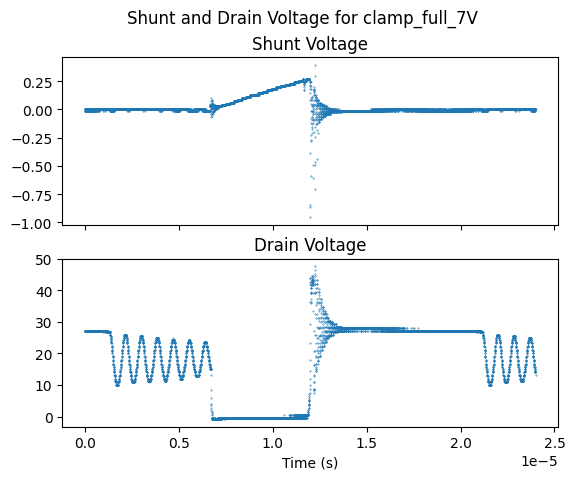

In [230]:
plot_vsh_vdr(["clamp_full_7"])

Q6: Setup clamp with R = 1500 Ohms and C = 100 nF. Attached third probe to cathode.

Q7: Captured cathode voltage along with previous measurements.

Q8: Increased to 8.08 V due to power constraint explained in Q5.

### Baseline Measurements

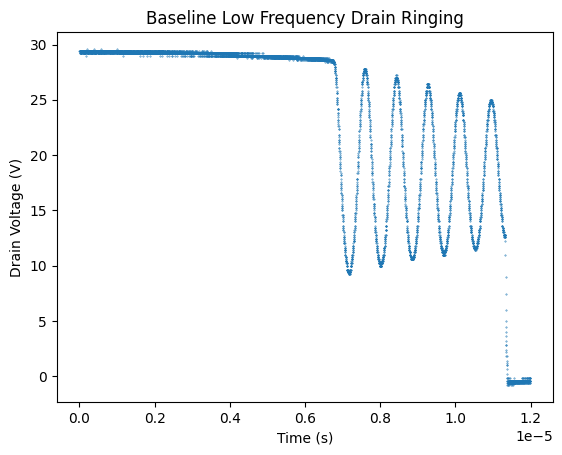

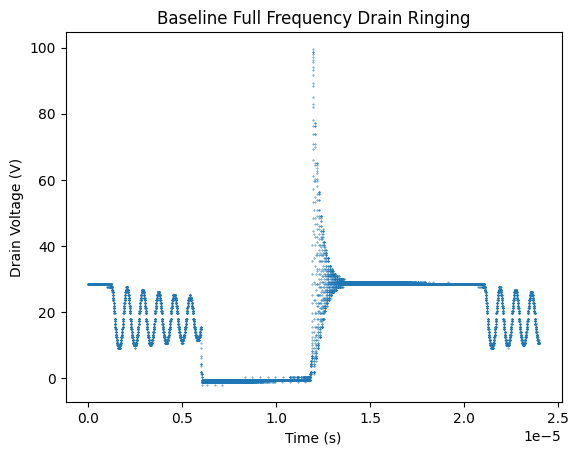

Q9:
For baseline low frequency ringing, the frequency is 1.277955271565495 MHz with zeta=0.013908.
For baseline high frequency ringing, the frequency is 10.362694300518115 MHz with zeta=0.040862.


In [214]:
plot_ringing(["Baseline Low", "Baseline Full"])
print("Q9:")

# Points chosen from interactive plot
baseline_low = get_ringing_characteristics([7.87e-6, 27.83], [1.10e-5, 24.93], 18, 4)
print(f"For baseline low frequency ringing, the frequency is {(baseline_low[0] * units.hertz).to_compact()} with zeta={baseline_low[1]:2f}.")

# Points chosen from interactive plot
baseline_high = get_ringing_characteristics([1.21795e-5, 65.3], [1.2662e-5, 38.9], 28.8, 5)
print(f"For baseline high frequency ringing, the frequency is {(baseline_high[0] * units.hertz).to_compact()} with zeta={baseline_high[1]:2f}.")

Q10: Our prep work capacitor values were inconsistent indicating an issue with our inductance values, but this issue was not identified until after the lab period. The low frequency capacitor was at 1.05 nF while the high frequency capacitor was at 0.26 nF. This matches our findings in Q11 where the oscilloscope-measured leakage inductance is lower than our LCR meter leakage inductance. The actual capacitor should be at 1.05 nF.

Q11: The frequency of the low frequency ringing is 12.3% that of the high frequency ringing. This ratio corresponds to the square root of the ratio between the inductance for each, as the frequency in rads/s for such low zetas is approximately $\frac{1}{\sqrt(LC)}$. Our capacitance stays the same, but the high frequency includes only leakage inductance for L. From this we find that our ratio is $\frac{\sqrt{\frac{1}{LC}}}{\sqrt{\frac{1}{L_{\text{leakage}}C}}} = \sqrt{\frac{L_\text{leakage}}{L}}$. This gives us a ratio of 0.015 of our leakage inductance to magnetizing inductance, which does not quite match our LCR meter readings, where it was 0.05 with a direct wire between our pins. However, both of these values will result in a similar order of magnitude, but our LCR measurement may have been inflated from even the the minimum length wire on the secondary coil.

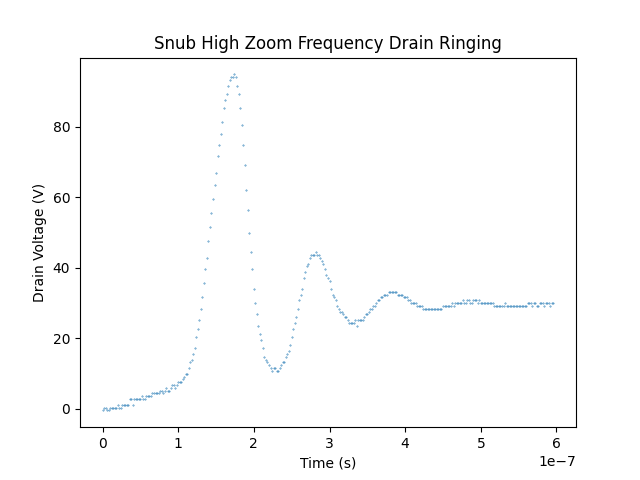

Q12: 
 A. For fast ringing, the damped frequency is 9.389671361502348 MHz with zeta=0.423057.


In [6]:
plot_ringing(["Snub High Zoom"])
# Use plot to get values for ringing characteristic
snub_high = get_ringing_characteristics([1.72e-7, 94.3], [3.85e-7, 32.6], 29, 2, baseline_high[0])
print(f"Q12: \n A. For fast ringing, the damped frequency is {(snub_high[0] * units.hertz).to_compact()} with zeta={snub_high[1]:2f}.")



(Note: I used the difference between the approximate natural frequency from our baseline and damped frequency to calculate our zeta value.)

B. We did not meet the goal of zeta=0.7 since 0.42 is far below this range. This issue can likely be attributed to an inaccurate value for our capacitor that came from the LCR meter measured leakage inductance that resulted in a lowered value for C. This lowered C value led to a lower Csb value that was not optimal (off by factor of 4!). Since this factor is square rooted to calculate our R value, we end up with zeta being off by about a factor of 2.

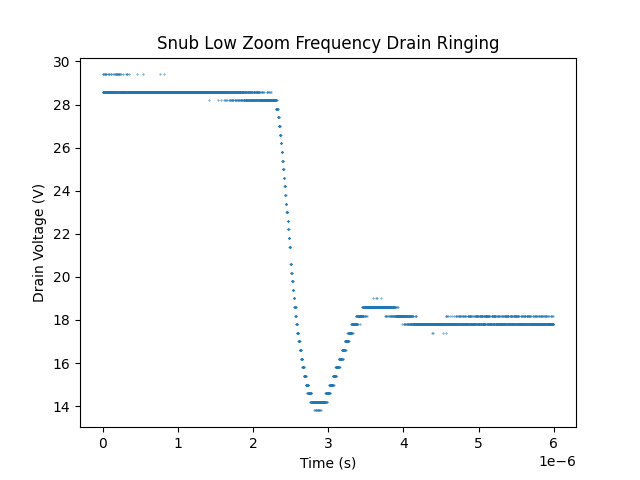

Q13: 
 A. For fast ringing, the damped frequency is 675.6756756756757 kHz with zeta=0.848799.


In [7]:
plot_ringing(["Snub Low Zoom"])
# Use plot to get values for ringing characteristic
snub_low = get_ringing_characteristics([2.87e-6, 13.68], [4.35e-6, 17.21], 18, 1, baseline_low[0])
print(f"Q13: \n A. For fast ringing, the damped frequency is {(snub_low[0] * units.hertz).to_compact()} with zeta={snub_low[1]:2f}.")

(Note: I used the difference between the approximate natural frequency from our baseline and damped frequency to calculate our zeta value.)

B. Our zeta value is closer to the range of 0.6 to 0.8 but is still outside this range. This can likely be attributed to the rounding made to get to actual capacitor and resistor values as well as a lack of trimming our resistor that could have resulted in an added loop inductance.

Q14: 
 A.


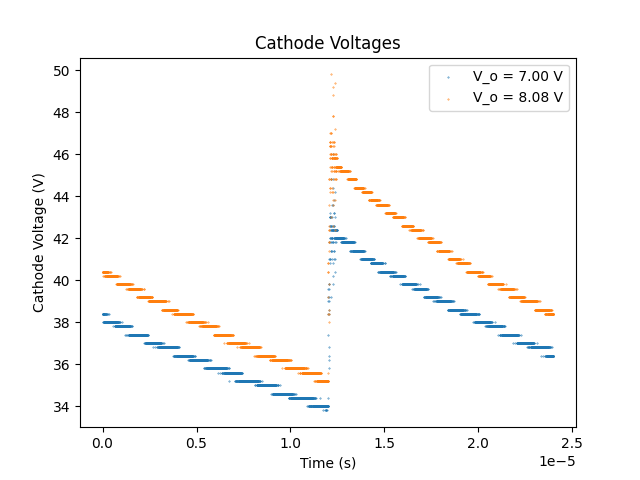

In [8]:
print("Q14: \n A.")
plot_vc16(["clamp_full_7", "clamp_full"])

B. The peak voltage for V_o = 7 is 46.0 V. For V_o = 8.08 V, it is 49.8 V. The peak-to-peak ripples are 12.2 V and 14.6 V respectively.

C. I started by using a curve fit to attempt to get our capacitance, normalizing the data to a single switching period: 

The capacitance is 56.16023763777604 nF


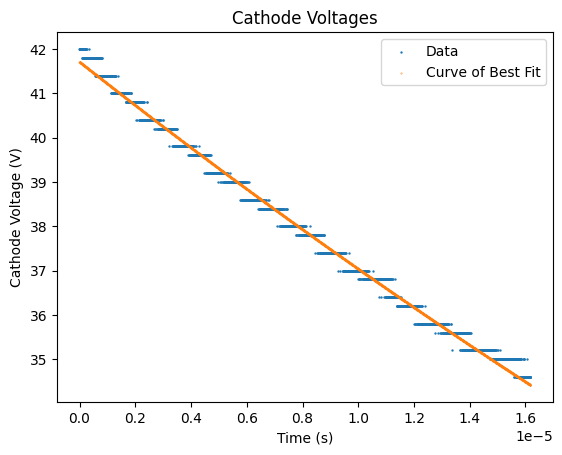

The capacitance is 47.30770911823571 nF


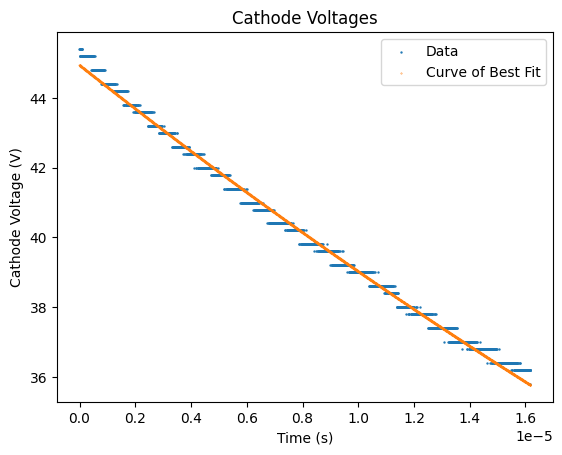

In [222]:
curve_fit_capacitance("clamp_full_7", [1, 5999], 3150)
curve_fit_capacitance("clamp_full", [1, 5999], 3150)


Since both produced values around 50 nF and our capacitor, I thought that perhaps the issue was poor quality data that was leading to extraneous residuals and worse curves. I switched to a method that averaged clumps of data points into buckets and received the same result.

Next, I tried using the equation for ripple to calculate our capacitance: $C = \frac{1}{R_{cp}\delta}(T_s - i_{pk} \frac{L_\text{leak}}{V_{cp} - \frac{V_o}{a}})$

In [225]:
fs = 50e3
Ts = 1/fs
Rcp = 1500
a = 0.8
L = 0.26e-6

V_ripple = [12.2, 14.6]
V_o = [7, 8.08]
ipk = [5.04, 5.39]
V_cp = [46, 49.8]

for i in range(2):
    C = (1/(Rcp * V_ripple[i]/V_cp[i]) * (Ts - (ipk[i]*(L)/(V_cp[i]-(V_o[i]/0.8)))))
    print((C*units.farad).to_compact())

50.184797154069024 nF
45.39918139470688 nF


This method produced a similar result. Parasitic inductance from long leads on the capacitor could also be changing the overall inductance to cause this result. I am also wondering if it possible that we accidentally used the incorrect capacitor or if the capacitor is non-linear at these operating points. 

D. No, they do not quite match. The simulation has higher peaks than the measured and has greater distance between the two voltages than the measured. Also, the peak to peak voltage is much lower in the simulation. Part of this may be attributed to modeling decisions made with a current switching limited MOSFET that I put in to avoid errors with voltage jumps that includes some leakage inductance and resistance that would change the drain voltage slightly. The overall shape and timing match.

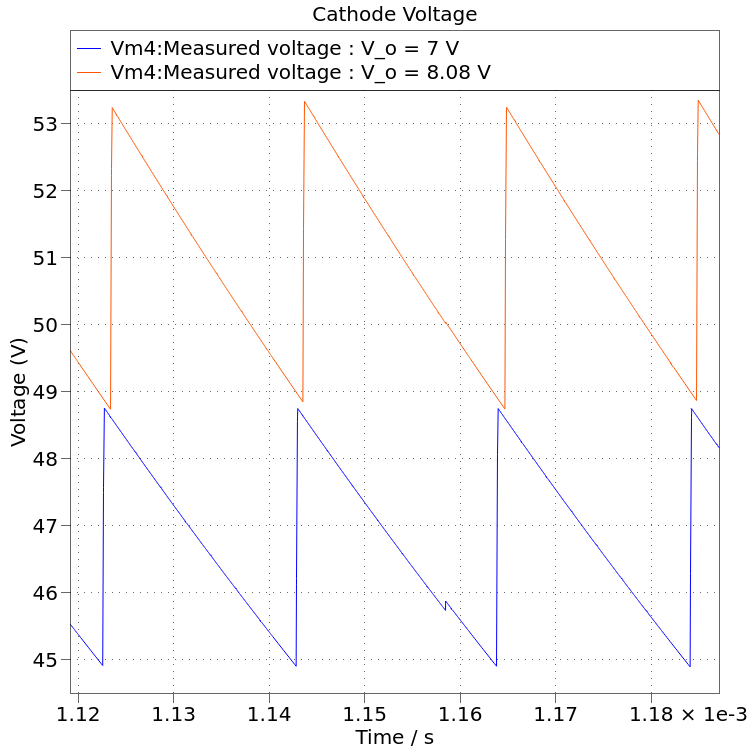